In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.50.post1', '1.0.1.post2')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/language-classifier/classification


In [5]:
path = Path('/home/gaurav/PycharmProjects/language-classifier/classification')

In [6]:
!ls

all_language_classification_model.ipynb  data_lm_export.pkl  models
all_languages.csv			 data_save.pkl


In [7]:
df = pd.read_csv(path/'all_languages.csv')
df.tail()

,text,label
1777558,ଉଚ୍ଚତାରେ ରହିଛି ।\n୨୦୦୧ ମସିହାର ଭାରତୀୟ ଜନଗଣନା ଅନ...,odia
1777559,ନସଂଖ୍ୟା ୪୨୫୭୪ ଅଟେ । ସେଥି ମଧ୍ୟରୁ ୫୨.୯୧% ଜଣ ପରୁଷ...,odia
1777560,ଁ ଦା‌‌ଭାଡେର ସାକ୍ଷରତା ହାର ୭୯.୩୯% ଅଟେ । ଏହା ଜାତୀ...,odia
1777561,ର ଠାରୁ ୧୪.୫୫% ପ୍ରତିଶତ କମ ଅଟେ । ସେଥିରୁ ୪୪.୧୫% ପ...,odia
1777562,ତି । ୧୧.୨୯% ଲୋକ ସେଠାରେ ୬ ବର୍ଷ ବୟସରୁ କମ ବୟସ୍କ ଅ...,odia


In [8]:
df['label'].unique()

array(['hindi', 'panjabi', 'sanskrit', 'marathi', 'malyalam', 'gujarati', 'kannada', 'nepali', 'bengali', 'odia'],
      dtype=object)

In [9]:
df.shape

(1777563, 2)

In [10]:
df[df['text'].isnull()].shape

(0, 2)

In [11]:
label_cols = list(range(1,df.shape[1]))

In [12]:
print(label_cols)

[1]


In [13]:
id_to_col = list(df.columns)

In [14]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [15]:
class AllLanguageTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/all_language.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [16]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/all_language.model"))
itos = [sp.IdToPiece(int(i)) for i in range(90000)]

In [17]:
# 90,000 is the vocab size that we chose in sentencepiece
all_language_vocab = Vocab(itos)

In [18]:
tokenizer = Tokenizer(tok_func=AllLanguageTokenizer, lang='all')

In [19]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [20]:
data_lm = TextLMDataBunch.from_csv(path=path, csv_name='all_languages.csv', text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=all_language_vocab)

In [21]:
data_lm.save('data_lm_export.pkl')

In [21]:
bs=64

In [22]:
data_lm.batch_size

64

In [24]:
data_lm.show_batch()

idx,text
0,"ं ▁ षष्टि का दि ▁। ▁एतत् सर्व ं ▁ त्वा ष्ट्र े ▁चित्र ा याम् ▁। ▁चित्र ा नक्षत्रे ▁शान्ति कर्म , ▁x x bo s ▁যা ন্ড ▁দলে ▁অনেক ▁প্রতিভা ধর ▁ব্যাটসম্যান ▁থাকায় ▁দলে ▁অবস্থান ▁নিশ্চিত করণ ে ▁তাঁকে ▁বোলার ▁হতে ▁হয়েছিল । ▁বোলার ▁হিসেবে ▁তিনি ▁নিখুঁত ▁বোলিং ▁করত ▁x x bo s ▁ ै कल्प िक ▁सिद्धान्त ले ▁मा चू ▁पिच ू ▁एक ▁कृषि ▁परीक्षण स्थल"
1,"▁of ▁a ▁word : ▁x x bo s ▁৭ ▁থেকে ▁১৫ - তম ▁অ্যাসোসিয়েশন ের ▁৩টি ▁করে , ▁১৬ ▁থেকে ▁২৬ - তম ▁অ্যাসোসিয়েশন ের ▁২টি ▁করে ▁এবং ▁বাকী ▁অ্যাসোসিয়েশন ের ▁১টি ▁করে ▁ক্লাব ▁এতে ▁x x bo s ▁തത്ത്വ ശാസ്ത്ര ഞ്ജ ൻ ▁കൂടിയാണ് ▁എന്നൊരു ▁കൃതി ▁കൂടി ▁രചിച്ച ിട്ടുണ്ട് . ▁ , ▁ഒട്ട മൂ ട ൻ ▁എ ▁x x bo s ▁ਵੀ ▁ਮਨੁਖ ੀ ▁ਮਨ ▁ਦੀ ▁ਇਹ ▁ਕਮਜ਼ੋਰ ੀ"
2,"▁- ▁ਫ਼ ਾਤ ਿਮਾ ▁ਸ਼ੇਖ਼ ▁ਇਕ ▁ਭਾਰਤ ▁x x bo s ▁യോഗ ിച്ച് ▁എല്ലാ ▁കോ ണ റ ുകളും ▁കാണ ാനുള്ള ▁ഒരു ▁ക്യാമറ കൂടി ▁അവിടെ ▁രൂപ പ്പെടുത്തി . ▁കണ്ണ ിന്റെ ▁പോര ായ് മ കൾ ▁മൊ ബൈ ൽ ▁ ഫോൺ ▁ഉപയോഗിച്ച് ▁കണ്ടെത്ത ാനുള്ള ▁ഒരു ▁ഉപകരണ ം ▁അദ്ദേഹത്തിന്റെ ▁ലാ ബ ിലെ ▁കൂട്ടായ്മ യിൽ ▁നിർ ▁x x bo s ▁ ा ▁सैन्य ाच्या ▁संरक्षण - धो रण ाला ▁पाठिंबा ▁होता , ▁परंतु ▁त्यांनी"
3,"<unk> ଷଧ ▁ନାମରେ ▁ଉପଲବ୍ ▁ଧ ▁ହୁଏ ▁। ▁ଏକ ▁ଡୋଜ ▁ପି ଛା ▁ହୋ ଲସେଲ ▁ମୂଲ୍ୟ ▁୦ . ୦୦ ୪ ରୁ ▁୦ . ୦୪ ▁ଆମେ ରି ▁x x bo s ▁ଚି ଙ୍ଗୁ ଡି ଧର ା ▁ଓ ▁ର ପ୍ ତା ନି ▁ଏଠାରେ ▁ମୁଖ୍ୟ ▁ବେ ପା ର ▁। ▁ଆ ଳି , ▁କେନ୍ଦ୍ରାପଡ଼ା , ▁ରାଜ କ ନିକା , ▁ପଟ୍ଟ ା ମୁ ଣ୍ଡ ାଇ , ▁ମାର୍ ଶା ଘ ାଇ , ▁ରାଜ ନଗର ▁କେନ୍ଦ୍ରାପଡ଼ା ▁ସହର କୁ"
4,"▁होत . ▁आपल्या ▁कीर्तन कले मु ळ ▁x x bo s ▁তে ▁জাতীয় ▁দলে ▁খেলার ▁জন্য ▁নির্বাচিত ▁হন । ▁১৯৪৬ ▁সালে ▁ভারত ▁দল ▁ইংল্যান্ড ▁সফরে ▁যায় । ▁ঐ ▁সফরে ▁লর্ডসে র ▁প্রথম ▁টেস্টে ▁খেলার ▁সুযোগ ▁পান ▁তিনি । ▁২২ ▁জুন , ▁১৯৪৬ ▁তারিখে ▁ইংল্যান্ডের ▁বিপক্ষে ▁বিজয় ▁হাজার ে ▁ও ▁বিন ু ▁মান কড় ের ▁স ▁x x bo s ▁क ▁मा ▁ओ त प्रो त ▁छ । ▁गार् गी"


In [23]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

/home/gaurav/anaconda3/envs/fastai-bleed/lib/python3.6/site-packages/fastai/datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


In [26]:
# Fine tuning the prtrained LM on current dataset

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


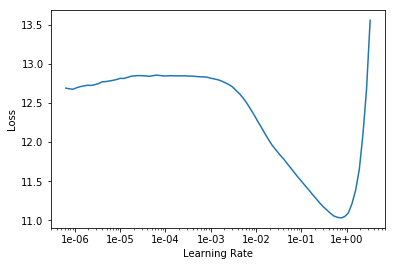

In [28]:
learn.recorder.plot()

In [29]:
learn.freeze()

In [30]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.971581,4.870046,0.307754,54:50


In [31]:
learn.save('first', with_opt=True)

In [36]:
learn.load('first', with_opt=True);

In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.471249,4.419579,0.340325,59:43


In [34]:
learn.save('second', with_opt=True)

In [24]:
learn.load('second', with_opt=True);

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


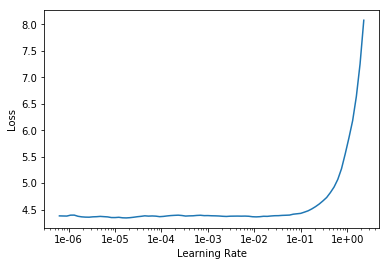

In [26]:
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.398503,4.341616,0.347923,54:47
1,4.343946,4.332032,0.349682,55:00


In [30]:
learn.save('third', with_opt=True)

In [40]:
learn.load('third', with_opt=True);

In [ ]:
# can train more but because of computational and time constraints, stopping training of LM here

In [31]:
learn.predict('શાહરૂખ ખાન સાથે',n_words=10)

'શાહરૂખ ખાન સાથે ▁લડ ્યા . ▁આ ▁સન્માન ક ▁સો ંબ લે ▁টাই'

In [32]:
learn.save_encoder('all_language_enc')

In [33]:
data_clas = TextClasDataBunch.from_csv(path=path, csv_name='all_languages.csv', tokenizer=tokenizer, vocab=all_language_vocab, text_cols=[0], label_cols=label_cols)

In [34]:
data_clas.show_batch()

text,target
▁x x bo s <unk> ▁l <unk> ▁m <unk> ▁n <unk> ▁o <unk> ▁p <unk> ▁q <unk> ▁r <unk> ▁s <unk> ▁t <unk> ▁u <unk> ▁v <unk> ▁w <unk> ▁x <unk> ▁y ▁ z ▁শীর্ষ ▁- ▁ 0–9 <unk> ▁a <unk> ▁b <unk> ▁c <unk> ▁d <unk> ▁e <unk> ▁f <unk> ▁g <unk> ▁h <unk> ▁i <unk> ▁j <unk> ▁k <unk> ▁l <unk> ▁m <unk> ▁n <unk> ▁o <unk> ▁p,bengali
▁x x bo s ▁28 ▁• ▁ 229 ▁• ▁230 ▁• ▁2 31 ▁• ▁23 2 ▁• ▁ 233 ▁• ▁2 34 ▁• ▁2 35 ▁• ▁2 36 ▁• ▁2 37 ▁• ▁2 38 ▁• ▁2 39 ▁• ▁240 ▁• ▁ 241 ▁• ▁24 2 ▁• ▁ 243 ▁• ▁24 4 ▁• ▁2 45 ▁• ▁2 46 ▁• ▁2 47 ▁• ▁2 48 ▁• ▁2 49 ▁• ▁250 ▁• ▁25,sanskrit
▁x x bo s ▁3 39 ▁• ▁3 40 ▁• ▁3 41 ▁• ▁34 2 ▁• ▁ 343 ▁• ▁3 44 ▁• ▁3 45 ▁• ▁3 46 ▁• ▁3 47 ▁• ▁3 48 ▁• ▁3 49 ▁• ▁350 ▁• ▁35 1 ▁• ▁35 2 ▁• ▁3 53 ▁• ▁3 54 ▁• ▁3 55 ▁• ▁3 56 ▁• ▁3 57 ▁• ▁3 58 ▁• ▁3 59 ▁• ▁360 ▁• ▁ 361,sanskrit
▁x x bo s ▁2 ▁• ▁7 33 ▁• ▁7 34 ▁• ▁7 35 ▁• ▁7 36 ▁• ▁7 37 ▁• ▁7 38 ▁• ▁7 39 ▁• ▁7 40 ▁• ▁7 41 ▁• ▁7 42 ▁• ▁7 43 ▁• ▁744 ▁• ▁7 45 ▁• ▁7 46 ▁• ▁7 47 ▁• ▁7 48 ▁• ▁7 49 ▁• ▁750 ▁• ▁75 1 ▁• ▁75 2 ▁• ▁75 3 ▁• ▁75 4 ▁•,sanskrit
▁x x bo s ▁• ▁10 23 ▁• ▁10 24 ▁• ▁10 25 ▁• ▁10 26 ▁• ▁10 27 ▁• ▁10 28 ▁• ▁10 29 ▁• ▁10 30 ▁• ▁10 31 ▁• ▁10 32 ▁• ▁10 33 ▁• ▁10 34 ▁• ▁10 35 ▁• ▁10 36 ▁• ▁10 37 ▁• ▁10 38 ▁• ▁10 39 ▁• ▁10 40 ▁• ▁10 41 ▁• ▁10 42 ▁• ▁10 43 ▁• ▁10 44,sanskrit


In [35]:
data_clas.sanity_check()

In [36]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

/home/gaurav/anaconda3/envs/fastai-bleed/lib/python3.6/site-packages/fastai/datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


In [37]:
learn.load_encoder('all_language_enc')

In [38]:
learn.freeze()

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


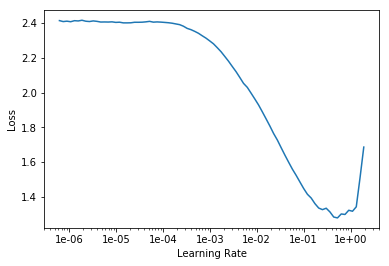

In [40]:
learn.recorder.plot()

In [41]:
learn.loss_func.func

CrossEntropyLoss()

In [42]:
kappa = KappaScore()

In [43]:
learn.metrics = [kappa, accuracy]

In [44]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.066946,0.039318,0.986847,0.988225,11:29


In [45]:
learn.save('first-full')

In [46]:
learn.load('first-full');

In [47]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.040262,0.030857,0.989194,0.990327,13:44


In [48]:
learn.save('second-full')

In [49]:
learn.load('second-full');

In [50]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.027080,0.028527,0.990244,0.991266,30:54


In [51]:
learn.save('final')

In [52]:
learn.load('final');

In [53]:
learn.predict('પ્રિયંકા ચોપડાને પતિ નિક પાસેથી મળી 2.7 કરોડ રૂપિયાની ગિફ્ટ, કિસ કરીને બોલી- લવ યૂ બેબી')

(Category gujarati,
 tensor(1),
 tensor([3.4170e-06, 9.9988e-01, 2.8218e-06, 8.3763e-06, 2.7963e-06, 1.6409e-05,
         7.9966e-06, 3.3894e-06, 6.5106e-06, 7.0642e-05]))

In [54]:
learn.predict("કલંકઃ 21 વર્ષ બાદ એકસાથે જોવા મળશે સંજય विकिपीडिया सभी विषयों पर प्रामाणिक और उपयोग, परिवर्तन")

(Category gujarati,
 tensor(1),
 tensor([1.0356e-04, 9.8104e-01, 1.7799e-02, 2.6421e-04, 1.2676e-04, 1.2063e-04,
         2.7969e-04, 6.6006e-05, 1.7085e-04, 2.9288e-05]))

In [55]:
learn.predict("विकिपीडिया सभी विषयों पर प्रामाणिक और उपयोग, परिवर्तन")

(Category hindi,
 tensor(2),
 tensor([1.2817e-04, 6.9185e-04, 9.9410e-01, 1.8238e-04, 1.2050e-04, 1.9287e-03,
         2.1868e-03, 6.3652e-05, 5.5892e-04, 4.1031e-05]))

In [56]:
learn.predict("বিষয়ক নিবন্ধ তৈরি করতে উইকি লাভস ওমেন ২০১৯ অনলাইন এডিটাথনে যোগ দিন જનકલી નોટો ઓળખવા માટે એક નવી સ્માર્ટફોન એપ આવી")

(Category bengali,
 tensor(0),
 tensor([9.7619e-01, 2.2613e-02, 7.3288e-05, 1.0816e-04, 1.1210e-04, 1.1946e-04,
         1.4435e-04, 1.1606e-04, 1.5883e-04, 3.6179e-04]))

In [ ]:
defaults.device = torch.device('cpu')
learn.model.eval()
learn.export()